<a href="https://colab.research.google.com/github/hxyder/xiaoyu/blob/main/Xiaoyu_Han_Recommendation_System_eCommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# eCommerce Product Recommendation - Part 1




# 1. Load Raw Data to Colab

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Laioffer/csv_files/RecSys_eComm/

/content/drive/MyDrive/Laioffer/csv_files/RecSys_eComm


In [ ]:
ls

aisles.csv          order_products_prior.csv  products.csv
departments.csv     order_products_train.csv
model_all_data.csv  orders.csv


In [ ]:
aisles = pd.read_csv('aisles.csv') 
departments = pd.read_csv('departments.csv') 
order_products_prior = pd.read_csv('order_products_prior.csv') 
order_products_train = pd.read_csv('order_products_train.csv') 
orders = pd.read_csv('orders.csv') 
products = pd.read_csv('products.csv') 

In [ ]:
print(aisles.shape)
print(departments.shape)
print(order_products_prior.shape)
print(order_products_train.shape)
print(orders.shape)
print(products.shape)

(134, 2)
(21, 2)
(793924, 4)
(53704, 4)
(82683, 7)
(49688, 4)


In [ ]:
#check the relationship
orders.head(100) # Dimensional Table
# order_id: order identifier
# user_id: customer identifier
# eval_set: which evaluation set this order belongs in (see SET described below)
# order_number: the order sequence number for this user (1 = first, n = nth)
# order_dow: the day of the week the order was placed on
# order_hour_of_day: the hour of the day the order was placed on
# days_since_prior: days since the last order capped at 30

# the NaN indicates that the order_number is 1, means there do not have prior order

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0
...,...,...,...,...,...,...,...
95,1647290,52,train,28,4,16,3.0
96,1583644,65,prior,1,0,9,NaN
97,3253911,65,prior,2,0,9,7.0
98,1422896,65,prior,3,0,10,14.0


In [ ]:
products.head() # Dimensional Table 
# product_id: product identifier
# product_name: name of the product
# aisle_id: foreign key
# department_id: foreign key

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
order_products_prior.head()  # Factor Table
# relationship of order and product
# "prior": orders prior to that users most recent order (~3.2m orders)
# reordered means orderded the product again, not what we want to predict

,order_id,product_id,add_to_cart_order,reordered
0,12,30597,1,1
1,12,15221,2,1
2,12,43772,3,1
3,12,37886,4,1
4,12,37215,5,0


In [ ]:
order_products_train.head() # Factor Table

,order_id,product_id,add_to_cart_order,reordered
0,1077,13176,1,1
1,1077,39922,2,1
2,1077,5258,3,1
3,1077,21137,4,1
4,1119,6046,1,1


# 2. Data Exploration

2.1 Build order history table

In [ ]:
# prior order details table 
PRIO_Detail = order_products_prior.merge(orders, on="order_id")
PRIO_Detail.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [ ]:
# Covert dow to string
PRIO_Detail["order_dow"] = PRIO_Detail["order_dow"].apply(lambda x:"Sunday" if x==0 else x)
PRIO_Detail["order_dow"] = PRIO_Detail["order_dow"].apply(lambda x:"Monday" if x==1 else x)
PRIO_Detail["order_dow"] = PRIO_Detail["order_dow"].apply(lambda x:"Tuesday" if x==2 else x)
PRIO_Detail["order_dow"] = PRIO_Detail["order_dow"].apply(lambda x:"Wednesday" if x==3 else x)
PRIO_Detail["order_dow"] = PRIO_Detail["order_dow"].apply(lambda x:"Thursday" if x==4 else x)
PRIO_Detail["order_dow"] = PRIO_Detail["order_dow"].apply(lambda x:"Friday" if x==5 else x)
PRIO_Detail["order_dow"] = PRIO_Detail["order_dow"].apply(lambda x:"Saturday" if x==6 else x)

In [ ]:
PRIO_Detail.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,Saturday,8,10.0
1,12,15221,2,1,152610,prior,22,Saturday,8,10.0
2,12,43772,3,1,152610,prior,22,Saturday,8,10.0
3,12,37886,4,1,152610,prior,22,Saturday,8,10.0
4,12,37215,5,0,152610,prior,22,Saturday,8,10.0


2.2 Visualize order frequency on DoW

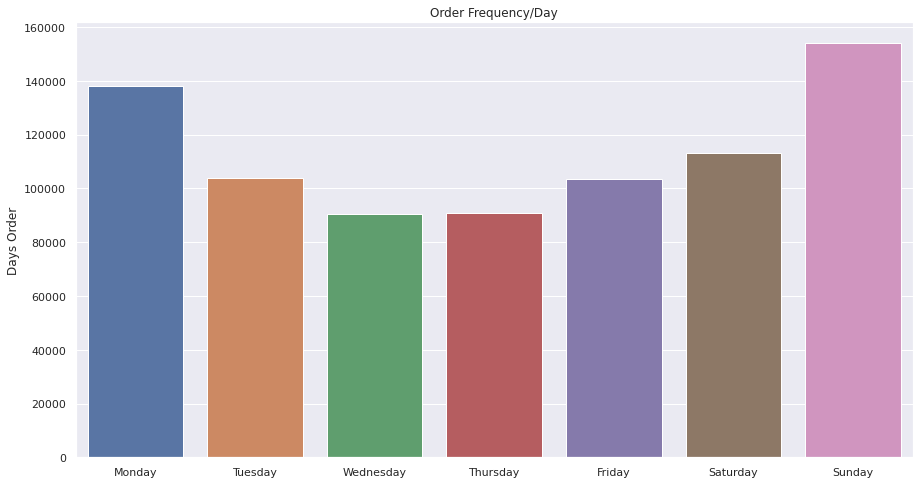

In [ ]:
#Frequency of Order Based on Days
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.countplot(x="order_dow",data=PRIO_Detail,
                   order=["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Order Frequency/Day")
plt.xlabel("")
plt.ylabel("Days Order")
plt.show()

1.3 Visualize order frequency on HoD

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


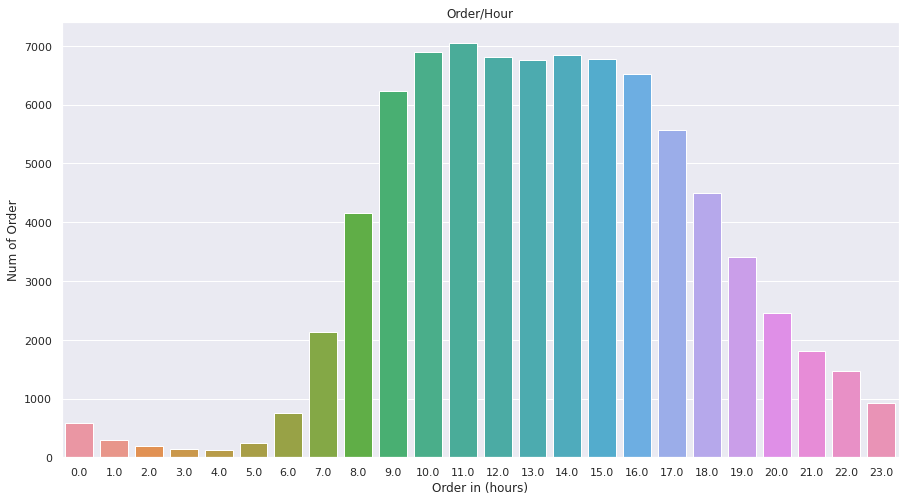

In [ ]:
hours_counts = orders.groupby("order_id")["order_hour_of_day"].mean().reset_index()
hod_stats = hours_counts.order_hour_of_day.value_counts()
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(hod_stats.index, hod_stats.values)
plt.title("Order/Hour")
plt.ylabel("Num of Order")
plt.xlabel('Order in (hours)')
plt.show()


**---》Most orders are generated during people's working hours**

1.4 Reorder Pattern Analysis

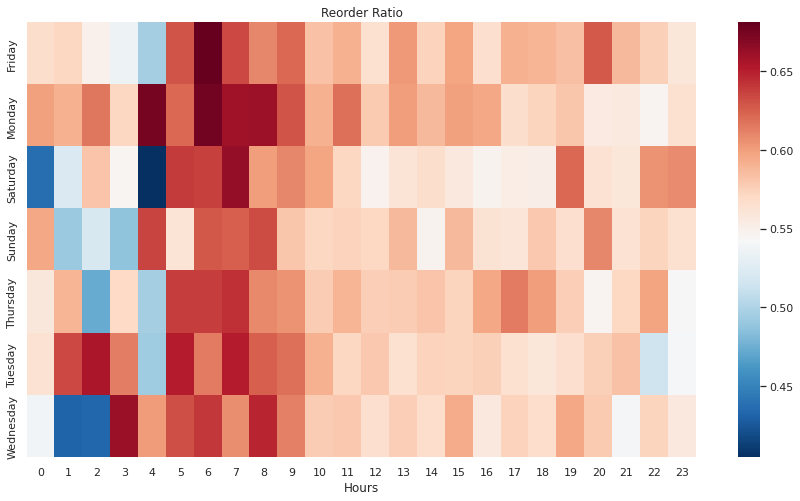

In [ ]:
reorder_Heat = PRIO_Detail.groupby(["order_dow", "order_hour_of_day"])["reordered"].mean().reset_index()
reorder_Heat = reorder_Heat.pivot('order_dow', 'order_hour_of_day', 'reordered')
plt.figure(figsize=(15,8))
sns.heatmap(reorder_Heat,cmap="RdBu_r")
plt.title("Reorder Ratio")
plt.ylabel("")
plt.xlabel("Hours")
plt.show()

**The reorder ratio is higher between 4am and 8am on Friday and Monday. Probably for many it's the start and end of the week. interesting. We should have enough stock ahead of them...etc.**

# 2. Data Quality Check

2.1. Validate the `days_since_prior_order` column in orders table

In [ ]:
orders.head() # days since the last order 
#the model do not suopport NaN.

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1363380,50,prior,1,3,9,NaN
1,3131103,50,prior,2,6,12,10.0
2,2197066,50,prior,3,1,13,9.0
3,3201640,50,prior,4,0,11,6.0
4,2756806,50,prior,5,4,14,11.0


In [ ]:
print("size of the order dataset: ", orders.shape[0])
print("NaN count in days_since_prior_order: ", orders[orders.days_since_prior_order.isnull()].shape[0])
print("order_number 1 count in orders table: ", orders[orders.order_number == 1].drop_duplicates().shape[0])
print("user_id count in orders table: ", orders.user_id.drop_duplicates().shape[0])

size of the order dataset:  82683
NaN count in days_since_prior_order:  5000
order_number 1 count in orders table:  5000
user_id count in orders table:  5000


**We can find that there have 5000 users...**

2.2.Validate Valid orders matching in the prior table

In [ ]:
# orders.csv，the num of orders in different eval_set：
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('order_id','nunique')]))

,eval_set,order_id
0,prior,77683
1,train,5000


In [ ]:
# check all of the order_id from order_products_prior.cs are in the orders.csvv 
#matching
  
print("order_id count in prior: ", order_products_prior['order_id'].nunique())
print("order_id from prior found in orders: ", order_products_prior[order_products_prior.order_id.isin(orders.order_id)].order_id.nunique())

order_id count in prior:  77683
order_id from prior found in orders:  77683


2.3. Validate orders matching in the train table

In [ ]:
print("orders count in train: ", order_products_train['order_id'].nunique())
print("order_id from train found in orders: ", order_products_train[order_products_train.order_id.isin(orders.order_id)].order_id.nunique())

orders count in train:  5000
order_id from train found in orders:  5000


2.4. Validate the intersection between prior and train table

In [ ]:
print("order_id intersection between prior and train: ", pd.merge(order_products_prior, order_products_train, on = ['order_id']).shape[0])

order_id intersection between prior and train:  0


2.5. Validate the user_id matching in prior and train set

In [ ]:
orders.groupby(['eval_set'], as_index=False).agg(OrderedDict([('user_id','nunique')]))

,eval_set,user_id
0,prior,5000
1,train,5000


In [ ]:
prior_user_ids = set(orders[orders['eval_set'] == 'prior']['user_id'])
train_user_ids = set(orders[orders['eval_set'] == 'train']['user_id'])
print("user_ids in prior: ", len(prior_user_ids))
print("user_ids in train: ", len(train_user_ids))
print("intersection of prior and train: ", len(prior_user_ids.intersection(train_user_ids)))

user_ids in prior:  5000
user_ids in train:  5000
intersection of prior and train:  5000


# Part2

## 1.Construct Model Label

In this part, we want to create model. the first thing we need to do is create label and feature

In [ ]:
# combine the user_id and product_id 
train_id_details = order_products_train.merge(orders, on='order_id')
train_user_ID = set(orders[orders['eval_set']=='train']['user_id'])
train_user_product = train_id_details['user_id'].astype('str') + '_' + train_id_details['product_id'].astype('str')

In [ ]:
train_user_product.head()

0    173934_13176
1    173934_39922
2     173934_5258
3    173934_21137
4     129386_6046
dtype: object

In [ ]:
# do the same thing for  prior 
prior_id_details  =order_products_prior.merge(orders,on='order_id')

In [ ]:
#model all data
#make sure prior user_id can match the train user_id
model_data = prior_id_details[prior_id_details.user_id.isin(train_user_ID)][['user_id','product_id','order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order']]
#one user should only have one row data for on product
model_data = model_data.drop_duplicates(subset=['user_id','product_id'])
model_data['new_key'] = model_data['user_id'].astype('str') + '_' + model_data['product_id'].astype('str')

In [ ]:
#create label 
# only the user_id and product_id(eg.new_key) in both train_user_product and model_data, the label is 1(means reordered) otherwise 0
model_data['label'] = 0
model_data.loc[model_data.new_key.isin(train_user_product),'label'] = 1

In [ ]:
model_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,new_key,label
0,152610,30597,22,6,8,10.0,152610_30597,0
1,152610,15221,22,6,8,10.0,152610_15221,0
2,152610,43772,22,6,8,10.0,152610_43772,0
3,152610,37886,22,6,8,10.0,152610_37886,0
4,152610,37215,22,6,8,10.0,152610_37215,0


## 2.Construct Model Features

### 2.1. Feature Group 1: user and products

In [ ]:
#set the features' name we want
user_products = ['UP_total_orders',
          'UP_add_to_cart_order_mean',
          'UP_reordered_mean',
          'UP_most_DOW',
          'UP_mpst_HOD']


In [ ]:
prior_id_details.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,12,30597,1,1,152610,prior,22,6,8,10.0
1,12,15221,2,1,152610,prior,22,6,8,10.0
2,12,43772,3,1,152610,prior,22,6,8,10.0
3,12,37886,4,1,152610,prior,22,6,8,10.0
4,12,37215,5,0,152610,prior,22,6,8,10.0


In [ ]:
#calculate each columns value
df_user_products = (prior_id_details.groupby(['product_id','user_id'],as_index=False)
                                    .agg(OrderedDict(
                                        [('order_id','count'),# how many times does user brought a products
                                         ('add_to_cart_order','mean'), 
                                         ('reordered','mean'),
                                         ('order_dow',(lambda x: x.mode()[0])), #the most day of user brought a product on which day in a weak
                                         ('order_hour_of_day',(lambda x: x.mode()[0])),
                                         ])))
df_user_products.columns = ['product_id',"user_id"] + user_products


In [ ]:
df_user_products.head()

,product_id,user_id,UP_total_orders,UP_add_to_cart_order_mean,UP_reordered_mean,UP_most_DOW,UP_mpst_HOD
0,1,21285,1,3.0,0.00,0,15
1,1,47549,4,4.0,0.75,2,14
2,1,54136,1,3.0,0.00,2,13
3,1,54240,1,2.0,0.00,2,16
4,1,95730,1,1.0,0.00,1,14


In [ ]:
#merge the data between model_data and df_user_products
model_data = model_data.merge(df_user_products, on = ['user_id','product_id'])

In [ ]:
model_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,new_key,label,UP_total_orders,UP_add_to_cart_order_mean,UP_reordered_mean,UP_most_DOW,UP_mpst_HOD
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,0.800,6,13
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,0.875,4,9
2,152610,43772,22,6,8,10.0,152610_43772,0,2,3.00,0.500,5,8
3,152610,37886,22,6,8,10.0,152610_37886,0,2,3.50,0.500,6,8
4,152610,37215,22,6,8,10.0,152610_37215,0,1,5.00,0.000,6,8


### 2.2. Feature Group 2: product features

In [ ]:
#named the products' features

product_features = ['total_orders_product',
           'add_to_cart_order_mean_product',
           'total_users_product',
           'reordered_mean_product',
           'most_DOW_product',
           'most_HOD_product',
           'days_since_prior_order_mean_product'         ]

In [ ]:
#new dataframe
df_product_features = (prior_id_details.groupby(['product_id'],as_index=False)
              .agg(OrderedDict(
                  [('order_id','nunique'),
                   ('add_to_cart_order','mean'),
                   ('user_id','nunique'),
                   ('reordered','mean'),
                   ('order_dow',(lambda x: x.mode()[0])),
                   ('order_hour_of_day',(lambda x: x.mode()[0])),
                   ('days_since_prior_order','mean')])))
df_product_features.columns = ['product_id'] + product_features

In [ ]:
df_product_features.head()

,product_id,total_orders_product,add_to_cart_order_mean_product,total_users_product,reordered_mean_product,most_DOW_product,most_HOD_product,days_since_prior_order_mean_product
0,1,26,4.576923,12,0.538462,3,10,16.280000
1,2,1,3.000000,1,0.000000,4,12,2.000000
2,3,1,4.000000,1,0.000000,4,17,30.000000
3,4,10,8.100000,5,0.500000,1,9,21.888889
4,8,1,25.000000,1,0.000000,0,13,30.000000


In [ ]:
#merge the feature into the model_data
model_data = model_data.merge(df_product_features, on=['product_id'])

In [ ]:
model_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,new_key,label,UP_total_orders,UP_add_to_cart_order_mean,UP_reordered_mean,UP_most_DOW,UP_mpst_HOD,total_orders_product,add_to_cart_order_mean_product,total_users_product,reordered_mean_product,most_DOW_product,most_HOD_product,days_since_prior_order_mean_product
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.000000,0.800000,6,13,85,4.2,23,0.729412,3,9,12.592593
1,112604,30597,15,3,10,1.0,112604_30597,0,5,3.800000,0.800000,0,10,85,4.2,23,0.729412,3,9,12.592593
2,75304,30597,28,2,8,12.0,75304_30597,0,2,29.000000,0.500000,2,8,85,4.2,23,0.729412,3,9,12.592593
3,22499,30597,20,4,9,30.0,22499_30597,1,18,2.722222,0.944444,2,9,85,4.2,23,0.729412,3,9,12.592593
4,190626,30597,11,1,9,14.0,190626_30597,0,9,2.111111,0.888889,1,9,85,4.2,23,0.729412,3,9,12.592593


In [ ]:
#merge the product into the model_data(we want the aisle_id and department_id)
model_data = model_data.merge(products[['product_id','aisle_id','department_id']], on = ['product_id'])
model_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,new_key,label,UP_total_orders,UP_add_to_cart_order_mean,...,UP_mpst_HOD,total_orders_product,add_to_cart_order_mean_product,total_users_product,reordered_mean_product,most_DOW_product,most_HOD_product,days_since_prior_order_mean_product,aisle_id,department_id
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.000000,...,13,85,4.2,23,0.729412,3,9,12.592593,53,16
1,112604,30597,15,3,10,1.0,112604_30597,0,5,3.800000,...,10,85,4.2,23,0.729412,3,9,12.592593,53,16
2,75304,30597,28,2,8,12.0,75304_30597,0,2,29.000000,...,8,85,4.2,23,0.729412,3,9,12.592593,53,16
3,22499,30597,20,4,9,30.0,22499_30597,1,18,2.722222,...,9,85,4.2,23,0.729412,3,9,12.592593,53,16
4,190626,30597,11,1,9,14.0,190626_30597,0,9,2.111111,...,9,85,4.2,23,0.729412,3,9,12.592593,53,16


In [ ]:
model_data.rename(columns={'aisle_id': 'aisled_id_product','department_id':'department_id_product'},inplace = True)

### 2.3. Feature Group 3: user features

In [ ]:
features_of_user = ['order_count_user',
           'product_count_user',
           'days_since_prior_order_mean_user',
           'reordered_mean_user',
           'most_DOW_user',
           'most_HOD_user',]

In [ ]:
df_features_of_user = (prior_id_details.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                        [('order_id','nunique'),
                         ('product_id','count'),
                         ('days_since_prior_order','mean'),
                         ('reordered','mean'),
                         ('order_dow',(lambda x: x.mode()[0])),
                         ('order_hour_of_day',(lambda x: x.mode()[0])),]
                    )))
df_features_of_user.columns = ['user_id'] + features_of_user

In [ ]:
model_data = model_data.merge(df_features_of_user, on = ['user_id'])

In [ ]:
model_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,new_key,label,UP_total_orders,UP_add_to_cart_order_mean,...,most_HOD_product,days_since_prior_order_mean_product,aisled_id_product,department_id_product,order_count_user,product_count_user,days_since_prior_order_mean_user,reordered_mean_user,most_DOW_user,most_HOD_user
0,152610,30597,22,6,8,10.0,152610_30597,0,5,2.00,...,9,12.592593,53,16,26,408,10.953804,0.375,6,12
1,152610,15221,22,6,8,10.0,152610_15221,0,8,8.25,...,12,13.653846,84,16,26,408,10.953804,0.375,6,12
2,152610,43772,22,6,8,10.0,152610_43772,0,2,3.00,...,12,12.008565,83,4,26,408,10.953804,0.375,6,12
3,152610,37886,22,6,8,10.0,152610_37886,0,2,3.50,...,14,11.489362,53,16,26,408,10.953804,0.375,6,12
4,152610,37215,22,6,8,10.0,152610_37215,0,1,5.00,...,13,11.490066,98,7,26,408,10.953804,0.375,6,12


In [ ]:
model_data['label'].value_counts()

0    297467
1     32339
Name: label, dtype: int64

In [ ]:
model_data.shape

(329806, 28)

## 3. Save feature data to google drive

In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
model_data.to_csv('model_data.csv',index=False)

# Part3

## 1.Load Feature Data

In [ ]:
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline 
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import keras
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
unique_key = ['user_id', 'product_id']
features = ['order_number',
            'order_dow',
            'order_hour_of_day',
            'days_since_prior_order',
            'UP_total_orders',
            'UP_add_to_cart_order_mean',
            'UP_reordered_mean',
            'UP_most_DOW',
            'UP_mpst_HOD',
            'total_orders_product',
            'add_to_cart_order_mean_product',
            'total_users_product',
            'reordered_mean_product',
            'most_DOW_product',
            'most_HOD_product',
            'days_since_prior_order_mean_product',
            'order_count_user',
            'product_count_user',
            'days_since_prior_order_mean_user',
            'reordered_mean_user',
            'most_DOW_user',
            'most_HOD_user',
            'aisled_id_product',
            'department_id_product',]
label = ['label']

In [ ]:
#make it more clearly, and we don't need use_id_product_id
model_data = model_data[unique_key + features + label]

In [ ]:
model_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,UP_total_orders,UP_add_to_cart_order_mean,UP_reordered_mean,UP_most_DOW,...,days_since_prior_order_mean_product,order_count_user,product_count_user,days_since_prior_order_mean_user,reordered_mean_user,most_DOW_user,most_HOD_user,aisled_id_product,department_id_product,label
0,152610,30597,22,6,8,10.0,5,2.00,0.800,6,...,12.592593,26,408,10.953804,0.375,6,12,53,16,0
1,152610,15221,22,6,8,10.0,8,8.25,0.875,4,...,13.653846,26,408,10.953804,0.375,6,12,84,16,0
2,152610,43772,22,6,8,10.0,2,3.00,0.500,5,...,12.008565,26,408,10.953804,0.375,6,12,83,4,0
3,152610,37886,22,6,8,10.0,2,3.50,0.500,6,...,11.489362,26,408,10.953804,0.375,6,12,53,16,0
4,152610,37215,22,6,8,10.0,1,5.00,0.000,6,...,11.490066,26,408,10.953804,0.375,6,12,98,7,0


## 2.Feature Data Analysis & Tranformation

### 2.1. Label Ratio

In [ ]:
label_value_count = model_data.label.value_counts()
print('total Negative label is: ', label_value_count[0])
print('total Positive label is: ', label_value_count[1])
print("Positive label ratio is {:.2f}%".format(label_value_count[1] / (label_value_count[0] + label_value_count[1])*100))

total Negative label is:  297467
total Positive label is:  32339
Positive label ratio is 9.81%


### 2.2. Null value check

In [ ]:
model_data.isna().sum()

user_id                                    0
product_id                                 0
order_number                               0
order_dow                                  0
order_hour_of_day                          0
days_since_prior_order                 29995
UP_total_orders                            0
UP_add_to_cart_order_mean                  0
UP_reordered_mean                          0
UP_most_DOW                                0
UP_mpst_HOD                                0
total_orders_product                       0
add_to_cart_order_mean_product             0
total_users_product                        0
reordered_mean_product                     0
most_DOW_product                           0
most_HOD_product                           0
days_since_prior_order_mean_product      726
order_count_user                           0
product_count_user                         0
days_since_prior_order_mean_user           0
reordered_mean_user                        0
most_DOW_u

### 2.3. Categorical Feature Transformation

In [ ]:
#
model_data = pd.concat([model_data.drop('department_id_product',axis=1),
     pd.get_dummies(model_data["department_id_product"],
                  prefix='product__department_id_')],
                     axis=1)


In [ ]:
model_data.head()

,user_id,product_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,UP_total_orders,UP_add_to_cart_order_mean,UP_reordered_mean,UP_most_DOW,...,product__department_id__12,product__department_id__13,product__department_id__14,product__department_id__15,product__department_id__16,product__department_id__17,product__department_id__18,product__department_id__19,product__department_id__20,product__department_id__21
0,152610,30597,22,6,8,10.0,5,2.00,0.800,6,...,0,0,0,0,1,0,0,0,0,0
1,152610,15221,22,6,8,10.0,8,8.25,0.875,4,...,0,0,0,0,1,0,0,0,0,0
2,152610,43772,22,6,8,10.0,2,3.00,0.500,5,...,0,0,0,0,0,0,0,0,0,0
3,152610,37886,22,6,8,10.0,2,3.50,0.500,6,...,0,0,0,0,1,0,0,0,0,0
4,152610,37215,22,6,8,10.0,1,5.00,0.000,6,...,0,0,0,0,0,0,0,0,0,0


## 3.Split Dataset to Train, Validation and Test

In [ ]:
#select 20% users as test data
#remaining data--->>(test data, validation data)

test_user_id = model_data.user_id.drop_duplicates().sample(frac=0.2)

validation_data = model_data[~model_data.user_id.isin(test_user_id)]
test_data = model_data[model_data.user_id.isin(test_user_id)]

In [ ]:
model_data.shape

(329806, 47)

In [ ]:
validation_data.shape

(267836, 47)

In [ ]:
test_data.shape

(61970, 47)

## 4.Model Selection with Cross Validation

### 4.1. Model Selection with All Features

In [ ]:
train_validation_x = validation_data.drop(['user_id', 'product_id', 'label'],axis=1)
train_validation_y = validation_data['label']

In [ ]:
classifiers = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ]

In [ ]:
def set_pipeline(classifier):
  steps = list()
  steps.append(('fillnan', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0.0)))
  steps.append(('downSample', RandomUnderSampler()))
  steps.append(('scaler', MinMaxScaler()))
  steps.append(('model', classifier))
  pipeline = Pipeline(steps=steps)
  return pipeline



In [ ]:
for classifier in classifiers:
  pipeline = set_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_x, train_validation_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('- - - - - -')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


CPU times: user 8.77 s, sys: 4.18 s, total: 13 s
Wall time: 7.53 s
LogisticRegression : F1 value is 34.527 (2.444)
- - - - - -
CPU times: user 6.37 s, sys: 88.6 ms, total: 6.46 s
Wall time: 6.37 s
DecisionTreeClassifier : F1 value is 24.549 (1.128)
- - - - - -
CPU times: user 59.1 s, sys: 359 ms, total: 59.5 s
Wall time: 59.2 s
RandomForestClassifier : F1 value is 33.377 (2.881)
- - - - - -
CPU times: user 27.1 s, sys: 177 ms, total: 27.3 s
Wall time: 27.3 s
AdaBoostClassifier : F1 value is 34.032 (3.223)
- - - - - -
CPU times: user 1min 32s, sys: 122 ms, total: 1min 32s
Wall time: 1min 31s
GradientBoostingClassifier : F1 value is 34.850 (3.255)
- - - - - -


### 4.2. Feature Selection

In [ ]:
#GradientBoostingClassifier has the highest F1 score
pipline_GradientBoosting = set_pipeline(GradientBoostingClassifier())
GB_classifier = pipline_GradientBoosting.fit(train_validation_x, train_validation_y)

In [ ]:
#get each feature's importance
feature_importance = GB_classifier.steps[3][1].feature_importances_
features = train_validation_x.columns.tolist()

In [ ]:
#sort the feature importance and select top15 features
DF_feature_importance = pd.DataFrame({"feature":features,"importance":feature_importance}).sort_values("importance",ascending = False)
TOP15_features = DF_feature_importance.head(15)

In [ ]:
TOP15_features

,feature,importance
16,order_count_user,0.304789
6,UP_reordered_mean,0.290842
4,UP_total_orders,0.210147
0,order_number,0.076324
12,reordered_mean_product,0.067201
19,reordered_mean_user,0.016932
9,total_orders_product,0.007517
3,days_since_prior_order,0.006993
17,product_count_user,0.003324
18,days_since_prior_order_mean_user,0.003085


In [ ]:
train_validation_x_features_selected = train_validation_x[TOP15_features['feature']]

### 4.3. Train Neural Network Model

In [ ]:
#Use nerual network
def NN_model():
  model = keras.Sequential([
     keras.layers.Dense(30, input_dim=15, activation='relu'),
     keras.layers.Dense(15, activation='relu'),
     keras.layers.Dense(5, activation='relu'),
     keras.layers.Dense(units=1, activation='sigmoid')
    ])
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model 

In [ ]:
#put the function into the model
NN_model = KerasClassifier(build_fn=NN_model, epochs=64, batch_size=32, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
#add the model to classifiers list
classifiers.append(NN_model)

In [ ]:
for classifier in classifiers:
  pipeline = set_pipeline(classifier)
  %time scores = cross_val_score(pipeline, train_validation_x_features_selected, train_validation_y, cv=5, scoring='f1')
  print(classifier.__class__.__name__, ': F1 value is %.3f (%.3f)' % (np.mean(scores)*100, np.std(scores)*100))
  print('- - - - - -')

#well, well, Keras your are not too bad, the variance is good!

CPU times: user 4.6 s, sys: 2.92 s, total: 7.52 s
Wall time: 4.19 s
LogisticRegression : F1 value is 34.533 (2.434)
- - - - - -
CPU times: user 4.01 s, sys: 109 ms, total: 4.12 s
Wall time: 4.05 s
DecisionTreeClassifier : F1 value is 24.524 (1.181)
- - - - - -
CPU times: user 54.8 s, sys: 208 ms, total: 55 s
Wall time: 54.9 s
RandomForestClassifier : F1 value is 33.254 (2.787)
- - - - - -
CPU times: user 16.5 s, sys: 111 ms, total: 16.6 s
Wall time: 16.6 s
AdaBoostClassifier : F1 value is 34.031 (3.206)
- - - - - -
CPU times: user 1min 2s, sys: 114 ms, total: 1min 2s
Wall time: 1min 2s
GradientBoostingClassifier : F1 value is 34.988 (3.314)
- - - - - -
CPU times: user 12min 49s, sys: 1min 6s, total: 13min 55s
Wall time: 10min 53s
KerasClassifier : F1 value is 34.573 (1.741)
- - - - - -


## 5.Hyper-parameter tuning for GradientBoostingClassifier

In [ ]:
#Considering the limited computing power of colab, I only select 10% of the original data for hyper-paremter tuning
mini_user_ids = validation_data.user_id.drop_duplicates().sample(frac=0.1)
validation_data_sample = validation_data[validation_data.user_id.isin(mini_user_ids)]


In [ ]:
validation_data_sample_x = validation_data_sample.drop(['user_id', 'product_id', 'label'],axis=1)[TOP15_features['feature']]
validation_data_sample_y = validation_data_sample['label']                                                                                                  

In [ ]:
param_grid = {
    'model__n_estimators': [100,150],
    'model__max_depth': [4,6],
    'model__min_samples_split': [2,4,6],
    'model__learning_rate': [0.005, 0.01],
}

In [ ]:
grid_s = GridSearchCV(set_pipeline(GradientBoostingClassifier()), cv=5, param_grid=param_grid, scoring='f1')
grid_s.fit(validation_data_sample_x, validation_data_sample_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('fillnan',
                                        SimpleImputer(fill_value=0.0,
                                                      strategy='constant')),
                                       ('downSample', RandomUnderSampler()),
                                       ('scaler', MinMaxScaler()),
                                       ('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model__learning_rate': [0.005, 0.01],
                         'model__max_depth': [4, 6],
                         'model__min_samples_split': [2, 4, 6],
                         'model__n_estimators': [100, 150]},
             scoring='f1')

In [ ]:
print("Best F1 value is %.3f" % grid_s.best_score_)
print("Params are %s" % grid_s.best_params_)

Best F1 value is 0.343
Params are {'model__learning_rate': 0.01, 'model__max_depth': 4, 'model__min_samples_split': 4, 'model__n_estimators': 100}


## 6.Train the final GradientBoostingClassifier

### 6.1.Train the final model with all training+validation data and the best hyper-parameters.

In [ ]:
GB_pipeline = set_pipeline(GradientBoostingClassifier(
    n_estimators=100,
    min_samples_split=2,
    max_depth=4,
    learning_rate=0.005,
))
GB_pipeline.fit(train_validation_x_features_selected,train_validation_y)

Pipeline(steps=[('fillnan', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('downSample', RandomUnderSampler()),
                ('scaler', MinMaxScaler()),
                ('model',
                 GradientBoostingClassifier(learning_rate=0.005, max_depth=4))])

In [ ]:
feature_importance = GB_pipeline.steps[3][1].feature_importances_
features = train_validation_x_features_selected.columns.tolist()
df_feature_importance = pd.DataFrame({"feature":features,"importance":feature_importance}).sort_values("importance",ascending = False)
df_feature_importance.head(15)



,feature,importance
1,UP_reordered_mean,0.336322
0,order_count_user,0.315571
2,UP_total_orders,0.285328
4,reordered_mean_product,0.035504
3,order_number,0.026328
6,total_orders_product,0.000474
11,add_to_cart_order_mean_product,0.000307
7,days_since_prior_order,0.000165
5,reordered_mean_user,0.000000
8,product_count_user,0.000000


## 7.Evaluate model on Test Data

### 7.1.Predict product reorder on Test Data

In [ ]:
test_data_x_selected_features = test_data.drop(['user_id', 'product_id', 'label'],axis=1)[TOP15_features['feature']]
y_test = test_data['label']

In [ ]:
y_predict = GB_pipeline.predict(test_data_x_selected_features)

In [ ]:
df_output = pd.DataFrame(
    {"user_id":test_data.user_id,"product_id":test_data.product_id,"predict":y_predict,"label":test_data.label}
)

In [ ]:
df_output.head()

,user_id,product_id,predict,label
1100,190626,30597,1,0
1101,190626,47626,0,0
1102,190626,27086,1,0
1103,190626,13176,1,0
1104,190626,16797,1,0


In [ ]:
y_predict_prob = GB_pipeline.predict_proba(test_data_x_selected_features)[:,1]

### 7.2.Analyze classification result

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


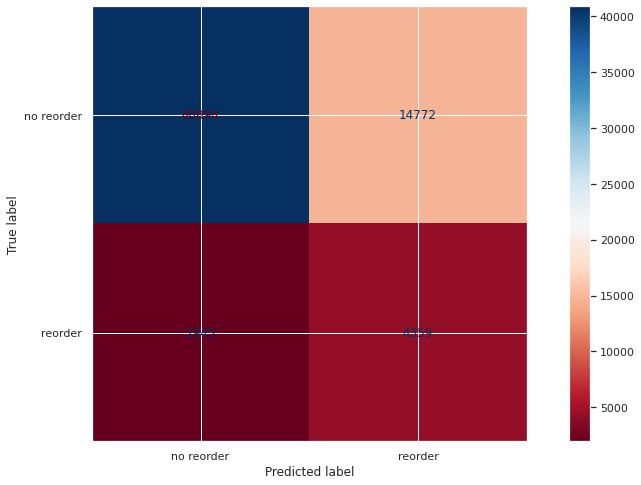

In [ ]:
plot_confusion_matrix(GB_pipeline,test_data_x_selected_features,y_test,display_labels=["no reorder","reorder"],cmap=plt.cm.RdBu)

In [ ]:
acc = accuracy_score(y_test,y_predict)
f1 = f1_score(y_test,y_predict)
pre = precision_score(y_test,y_predict)
rec = recall_score(y_test,y_predict)
auc = roc_auc_score(y_test,y_predict)

In [ ]:
print("F1 Score : {:.4%}".format(f1))
print("ROC AUC : {:.4%}".format(auc))
print("Accuracy : {:.4%}".format(acc))
print("Precision : {:.4%}".format(pre))
print("Recall : {:.4%}".format(rec))

F1 Score : 34.2756%
ROC AUC : 71.3049%
Accuracy : 73.0240%
Precision : 22.7850%
Recall : 69.1466%
